In [108]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics import accuracy_score,classification_report,pairwise_distances_argmin_min,silhouette_score, hamming_loss, f1_score, precision_score, recall_score, jaccard_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from preprocess_data import preprocess_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_distances,pairwise_distances
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.linear_model import SGDClassifier
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [109]:
dataset_name = 'ecommerce' # choose from 'imdb', 'academic_papers', 'legal', 'reviews', 'ecommerce'
data = preprocess_data(dataset_name)
#data['genre'].value_counts().plot(kind='bar')

/home/student/idan/DataAnalysisAndVisualizationProject/dataanalysisvisualizationfiles/code/preprocess_data.py:45: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(data_path)


In [110]:
if dataset_name == 'imdb' or dataset_name == 'academic_papers':
    data['num_genres'] = data['genre'].apply(len)
    data = data[data['num_genres'] == 1]
    
descriptions = data['description_processed'].tolist()
genres = data['genre'].apply(lambda x: x[0]).to_list() if dataset_name == 'academic_papers' else data['genre'].tolist() 
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(genres)
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
X = model.encode(descriptions, show_progress_bar=True)

/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Batches: 100%|██████████| 1576/1576 [10:16<00:00,  2.56it/s]


In [111]:
initial_train_size = 250
iterations = 20
uncertainty_threshold = 0.2
budget_per_iteration = 500
methods = ['random', 'cluster', 'faiss_lsh', 'combined']    
# methods = ['combined']    


In [112]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_full_normalized = normalize(X_train_full, axis=1, norm='l2')
X_test_normalized = normalize(X_test, axis=1, norm='l2')
np.random.seed(42)
initial_indices = np.random.choice(len(X_train_full_normalized), initial_train_size, replace=False)

### Code for Non-random Centroid Initialization

In [113]:
# centroid_sentences = genre_descriptions = [
#     "intense physical confrontations fast paced sequences featuring combat explosions high stakes conflict",
#     "epic journeys heroic quests dangerous adventures often in fantastical settings exploration unknown",
#     "animated storytelling visual artistry non-human characters imaginative worlds surreal narratives",
#     "detailed accounts real-life individuals focusing on personal achievements significant historical moments",
#     "comedic scenarios witty dialogues humor-based interactions aimed at evoking laughter entertainment",
#     "depictions organized crime criminal behavior investigations heists underworld activities law enforcement",
#     "deep emotional narratives character evolution often dealing with life-altering events personal challenges",
#     "family-friendly themes focusing on relationships nurturing positive lessons designed for younger audiences",
#     "magical realms supernatural beings mystical adventures crossing boundaries between reality imagination",
#     "historical recreations focusing on pivotal events important eras real historical figures shaping world events",
#     "crafted to evoke fear suspense often involving supernatural forces psychological terror or extreme violence",
#     "stories centered around music performers musicians using songs as narrative devices to advance plot",
#     "musical storytelling with elaborate performances dance sequences centered around theatrical music numbers",
#     "intricate narratives involving crime detective work solving mysteries uncovering secrets unexpected twists",
#     "narratives centered on romantic relationships emotional intimacy personal growth often amidst challenges",
#     "explorations advanced technology futuristic societies space travel speculative science uncharted concepts",
#     "competitive sports athletic achievement depicting struggles victories focus on physical and mental endurance",
#     "psychological tension high stakes thrillers featuring danger suspense shocking revelations complex plots",
#     "military combat war strategies depictions battles focusing on heroism sacrifice wartime experiences",
#     "western frontier themes cowboys outlaws gunfights rugged landscapes lawlessness moral dilemmas"
# ]

# centroid_vecs = model.encode(centroid_sentences, show_progress_bar=True)
# centroid_vecs = normalize(centroid_vecs, axis=1, norm='l2')
# centroid_vecs = np.array(centroid_vecs)

In [114]:
# def sample_non_random_init(method, X_train, X_pool, remaining_indices, budget):
#     if method == 'random':
#         return np.random.choice(remaining_indices, budget, replace=False)
    
#     elif method == 'cluster':
#         num_clusters = 20
#         #clustering = faiss.Clustering(X_train.shape[1], num_clusters)
#         #clustering.verbose = False
#         #clustering.niter = 50
#         remaining_data = np.array([X_pool[i] for i in remaining_indices]).astype('float32')
#         #index_flat = faiss.IndexFlatIP(X_train.shape[1])
#         #index_flat.add(centroid_vecs.astype('float32'))
#         #clustering.train(remaining_data, index_flat)
#         #D, cluster_assignments = index_flat.search(remaining_data, 1)
#         #cluster_assignments = cluster_assignments.flatten()
#         #centroids = faiss.vector_to_array(clustering.centroids).reshape(num_clusters, X_train.shape[1])
#         kmeans = KMeans(n_clusters=num_clusters, init=centroid_vecs, n_init=1, max_iter=100)
#         kmeans.fit(remaining_data)
#         cluster_assignments = kmeans.labels_
#         final_centroids = kmeans.cluster_centers_

#         selected_indices = []
#         for cluster in range(num_clusters):
#             cluster_indices = [i for i, label in zip(remaining_indices, cluster_assignments) if label == cluster]
#             if cluster_indices:
#                 num_to_select_from_cluster = min((int((500/num_clusters)/2)), int(len(cluster_indices)/2))
#                 cluster_data = X_pool[np.array(cluster_indices)]
#                 cluster_center = final_centroids[cluster].reshape(1, -1)
#                 distances = np.linalg.norm(cluster_data - cluster_center, axis=1)
#                 #distances, _ = index_flat.search(cluster_center, len(cluster_indices))
#                 closest_samples = set([cluster_indices[i] for i in distances[0].argsort()[:num_to_select_from_cluster]])

#                 pairwise_distances_matrix = pairwise_distances(cluster_data)
#                 diversity_scores = pairwise_distances_matrix.mean(axis=1)
#                 most_diverse_indices = set([cluster_indices[i] for i in np.argsort(-diversity_scores)[:num_to_select_from_cluster]])
#                 selected_indices.extend(list(closest_samples.union(most_diverse_indices)))

#         return selected_indices

### Continue Here

In [115]:
def find_distant_points(distance_method, D_pool, sample_size):
    """
    Find the most distant points in the pool based on the specified distance method.

    Parameters:
    - distance_method (str): The method to compute distances ('min', 'max', 'avg').
    - D_pool (np.ndarray): Distance matrix.
    - sample_size (int): Number of samples to select.

    Returns:
    - furthest_indices_within_remaining (np.ndarray): Indices of the most distant points.
    """
    if distance_method == 'min':
        distances = D_pool.min(axis=1)
    elif distance_method == 'max':
        distances = D_pool.max(axis=1)
    else:
        distances = D_pool.mean(axis=1)

    furthest_indices_within_remaining = np.argsort(distances)[-sample_size:]

    return furthest_indices_within_remaining

In [116]:
def sample(method, X_train, X_pool, remaining_indices, budget, clf, index = None):
    """
    Sample data points based on the specified method for active learning.

    Parameters:
    - method (str): The sampling method to use ('random', 'margin', 'entropy', 'cluster', 'faiss_lsh').
    - X_train (np.ndarray): The training data features.
    - X_pool (np.ndarray): The pool of data features to sample from.
    - remaining_indices (list): List of indices of the remaining data points in the pool.
    - budget (int): The number of samples to select.
    - clf (SGDClassifier): The classifier used for prediction and uncertainty estimation.
    - index (faiss.Index, optional): The FAISS index for approximate nearest neighbor search (required for 'faiss_lsh' method).

    Returns:
    - list: Indices of the selected data points from the pool.
    """
    if method == 'random':
        return np.random.choice(remaining_indices, budget, replace=False)
    
    elif method == 'margin':
        probs = clf.predict_proba(X_pool)
        sorted_probs = np.sort(probs, axis=1) 
        margins = sorted_probs[:, -1] - sorted_probs[:, -2]
        return np.argsort(margins)[:budget]  
    
    elif method == 'entropy':
        probs = clf.predict_proba(X_pool)
        entropies = -np.sum(probs * np.log(probs), axis=1)
        return np.argsort(entropies)[:budget]
    
    elif method == 'cluster':
        num_clusters = 20
        clustering = faiss.Clustering(X_train.shape[1], num_clusters)
        clustering.verbose = False
        clustering.niter = 50
        remaining_data = np.array([X_pool[i] for i in remaining_indices]).astype('float32')
        index_flat = faiss.IndexFlatIP(X_train.shape[1])
        clustering.train(remaining_data, index_flat)
        D, cluster_assignments = index_flat.search(remaining_data, 1)
        cluster_assignments = cluster_assignments.flatten()
        centroids = faiss.vector_to_array(clustering.centroids).reshape(num_clusters, X_train.shape[1])

        selected_indices = []
        for cluster in range(num_clusters):
            cluster_indices = [i for i, label in zip(remaining_indices, cluster_assignments) if label == cluster]
            if cluster_indices:
                num_to_select_from_cluster = min((int((500/num_clusters)/2)), int(len(cluster_indices)/3))
                cluster_data = X_pool[np.array(cluster_indices)]
                cluster_center = centroids[cluster].reshape(1, -1)
                distances, _ = index_flat.search(cluster_center, len(cluster_indices))
                closest_samples = [cluster_indices[i] for i in distances[0].argsort()[:num_to_select_from_cluster]]
                selected_indices.extend(closest_samples)

                pairwise_distances_matrix = pairwise_distances(cluster_data)
                diversity_scores = pairwise_distances_matrix.mean(axis=1)
                most_diverse_indices = set([cluster_indices[i] for i in np.argsort(-diversity_scores)[:num_to_select_from_cluster]])
                selected_indices.extend(most_diverse_indices)

                probs = clf.predict_proba(cluster_data)
                uncertainty = 1 - np.max(probs, axis=1)
                sorted_indices = np.argsort(-uncertainty)
                selected_cluster_indices = [cluster_indices[i] for i in sorted_indices[:num_to_select_from_cluster]]
                selected_indices.extend(selected_cluster_indices)
        return list(set(selected_indices))
    
    elif method == 'faiss_lsh':
        D_pool, _ = index.search(X_pool[remaining_indices], len(X_train))
        furthest_indices_within_remaining = find_distant_points('avg', D_pool, budget)
        return [remaining_indices[i] for i in furthest_indices_within_remaining]

In [117]:
acc_dict, f1_dict, prec_dict, rec_dict = {}, {}, {}, {}
for method in methods:
    print(f'Running active learning with {method} sampling')
    
    clf = SGDClassifier(loss='log_loss', random_state=42)
    accuracies, f1_scores, precs, recalls = [], [], [], []
    X_train = X_train_full_normalized[initial_indices]
    y_train = np.array(y_train_full)[initial_indices]
    remaining_indices = list(set(range(len(X_train_full_normalized))) - set(initial_indices))
    
    if method == 'faiss_lsh' or method == 'combined':
        ## IP index
        # index = faiss.IndexFlatIP(X_train_full_normalized.shape[1])

        ## LSH index
        nbits = 16  # Number of bits for hashing
        index = faiss.IndexLSH(X_train_full_normalized.shape[1], nbits)

        ## HNSW index
        # index = faiss.IndexHNSWFlat(X_train_full_normalized.shape[1], 32)

        index.add(X_train_full_normalized)

    for iteration in range(iterations):
        clf.partial_fit(X_train, y_train, classes=np.unique(y_train_full))
        y_pred = clf.predict(X_test_normalized)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        prec = precision_score(y_test, y_pred, average='macro')
        rec = recall_score(y_test, y_pred, average='macro')
        accuracies.append(acc)   
        f1_scores.append(f1)
        precs.append(prec)
        recalls.append(rec)
        
        print(f'Iteration {iteration + 1}/{iterations} - Accuracy: {acc}, F1: {f1}, Precision: {prec}, Recall: {rec}')
        if len(remaining_indices) == 0 or len(remaining_indices) < budget_per_iteration or len(X_train) >= len(X_train_full_normalized):
            break
        
        if method == 'faiss_lsh':
            selected_indices = sample(method, X_train, X_train_full_normalized, remaining_indices, budget_per_iteration, clf, index)
            index.add(X_train_full_normalized[selected_indices])
        elif method == 'combined':
            selected_cluster = sample('cluster', X_train, X_train_full_normalized, remaining_indices, budget_per_iteration // 2 , clf)
            remaining_cluster_indices = list(set(remaining_indices) - set(selected_cluster))
            selected_faiss = sample('faiss_lsh', X_train, X_train_full_normalized, remaining_cluster_indices, budget_per_iteration // 2, clf, index)
            selected_indices = selected_cluster + selected_faiss
            index.add(X_train_full_normalized[selected_indices])
        else:
            selected_indices = sample(method, X_train, X_train_full_normalized, remaining_indices, budget_per_iteration, clf)
        X_train = np.vstack((X_train, X_train_full_normalized[selected_indices]))
        y_train = np.concatenate((y_train, np.array(y_train_full)[selected_indices]))
        remaining_indices = list(set(remaining_indices) - set(selected_indices))
        
    print(classification_report(y_test, y_pred))
    acc_dict[method] = accuracies
    f1_dict[method] = f1_scores
    prec_dict[method] = precs
    rec_dict[method] = recalls
        

Running active learning with random sampling
Iteration 1/20 - Accuracy: 0.9075855230540406, F1: 0.9078965649691508, Precision: 0.9245796195442768, Recall: 0.8952566714201614
Iteration 2/20 - Accuracy: 0.9138324243926623, F1: 0.914302223250333, Precision: 0.9261074972659544, Recall: 0.9058469118974246
Iteration 3/20 - Accuracy: 0.9297967278135846, F1: 0.9309598961681119, Precision: 0.9398525673173175, Recall: 0.9236625532218892


Iteration 4/20 - Accuracy: 0.9279127416955875, F1: 0.9284098711208257, Precision: 0.93459898238176, Recall: 0.9246212826060941
Iteration 5/20 - Accuracy: 0.9360436291522063, F1: 0.9371322423211129, Precision: 0.9439231611980299, Recall: 0.9316097277094141
Iteration 6/20 - Accuracy: 0.930193356470005, F1: 0.9303719340231293, Precision: 0.9332159383592712, Recall: 0.9290910759995916
Iteration 7/20 - Accuracy: 0.9382250867625186, F1: 0.9389390736279379, Precision: 0.9386000894869704, Recall: 0.9395668402228278
Iteration 8/20 - Accuracy: 0.943282102131879, F1: 0.9441021019129929, Precision: 0.9453408127443867, Recall: 0.9430132794264334
Iteration 9/20 - Accuracy: 0.9378284581060982, F1: 0.9387327185604033, Precision: 0.934300903272099, Recall: 0.9438695217087945
Iteration 10/20 - Accuracy: 0.9429846306395637, F1: 0.9436558494427337, Precision: 0.943054808762373, Recall: 0.9442732346334138
Iteration 11/20 - Accuracy: 0.9446703024293506, F1: 0.945341196264953, Precision: 0.9467123025434213, 

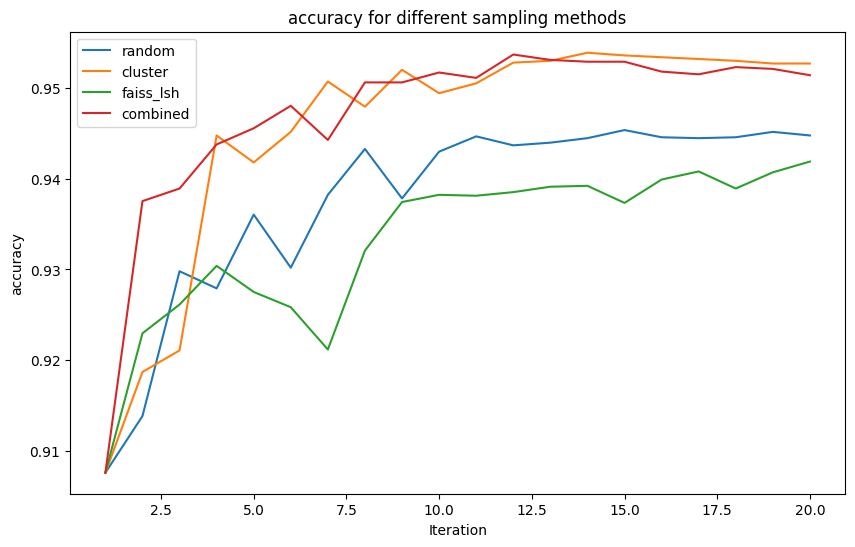

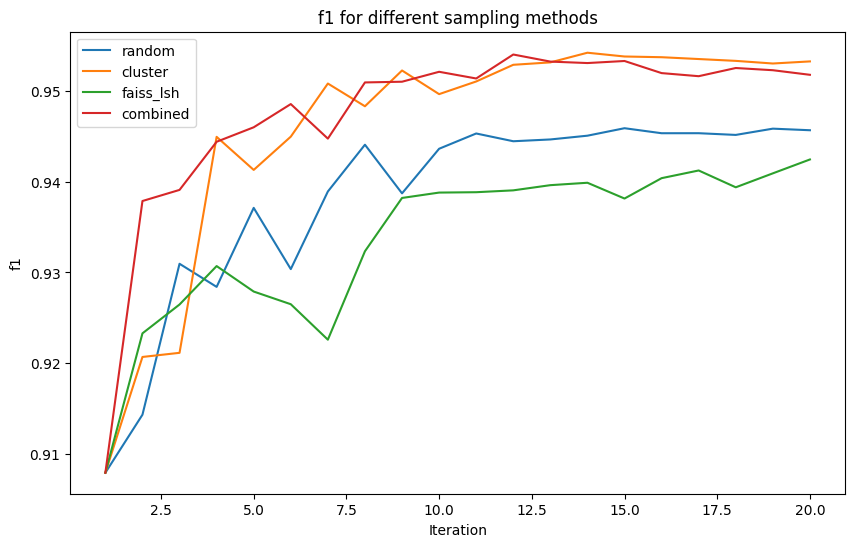

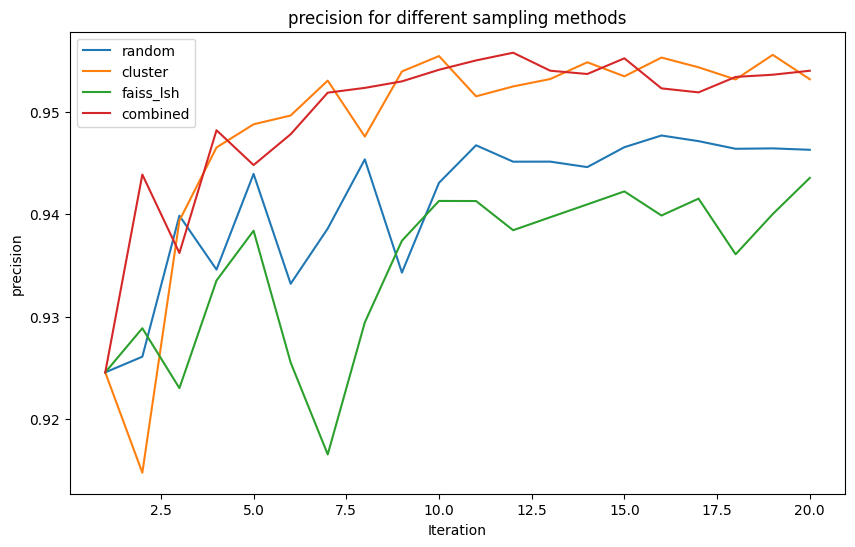

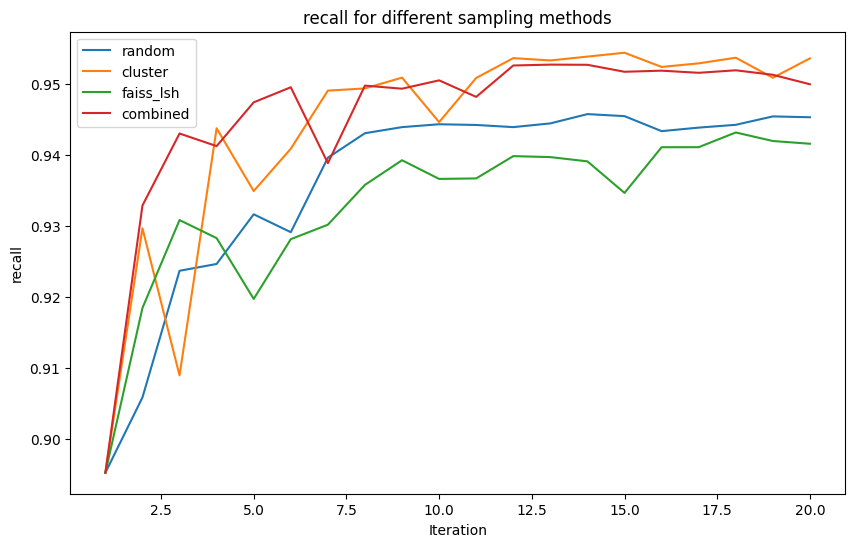

In [118]:

dics = {'accuracy': acc_dict, 'f1': f1_dict, 'precision': prec_dict, 'recall': rec_dict}
its = np.arange(1, iterations + 1)
for metric, dic in dics.items():
    plt.figure(figsize=(10, 6))
    for name, values in dic.items():
        sns.lineplot(x=its, y=values, label=name)
    plt.xlabel('Iteration')
    plt.ylabel(metric)
    plt.title(f'{metric} for different sampling methods')
    plt.legend()
    # plt.savefig(f'images/{dataset_name}_{metric}_active_learning.png')
    plt.savefig(f'../data/images/{dataset_name}_{metric}_active_learning_include_combine.png')
    plt.show()
 
